In [98]:
import os
import opendatasets as od
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from etl import ELTPipline

In [99]:
dataset = 'https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data'
od.download(dataset)

Skipping, found downloaded files in ".\competitive-data-science-predict-future-sales" (use force=True to force download)


In [100]:
file_paths = os.listdir('./competitive-data-science-predict-future-sales')

In [101]:
pipeline = ELTPipline()
df_s = list(map(lambda path: pipeline.exctraction(path), file_paths))
for df in df_s:
    pipeline.transform(df)


In [102]:
df_s[2]['date'] = pipeline.data_format(df_s[2]['date'])

In [103]:
df_s[2] = pipeline.outliers(df_s[2], group='item_id', val = 'item_price')


In [104]:
df_items = df_s[0]
df_item_categories = df_s[1]
df_sales_train = df_s[2]
df_sample_submission = df_s[3]
df_shops = df_s[4]
df_test = df_s[5]

In [105]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [106]:
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [107]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0


In [108]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [109]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [110]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [111]:
merge_params = [[df_items, 'item_id'], [df_item_categories, 'item_category_id'], [df_shops, 'shop_id']]
for params in merge_params:
    df_sales_train = pipeline.merge_(df_sales_train, params[0], params[1])
    df_test = pipeline.merge_(df_test, params[0], params[1])


In [112]:
df_test.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад"""
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад"""


In [113]:
'''
pipeline.load(df_sales_train, 'train.csv')
pipeline.load(df_test, 'test.csv')
'''

"\npipeline.load(df_sales_train, 'train.csv')\npipeline.load(df_test, 'test.csv')\n"

In [114]:
sales_per_month = df_sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])[['date','item_price', 'item_cnt_day']].agg({'date': 'mean','item_price': 'mean', 'item_cnt_day': 'sum'})
sales_per_month.head()

date  item_price  item_cnt_day
date_block_num shop_id item_id                                     
0              0       32      2013-01-20       221.0           6.0
                       715     2013-01-19        91.0           3.0
                       810     2013-01-16       120.0           4.0
                       997     2013-01-08        58.0           1.0
                       1091    2013-01-28       110.0           1.0

In [115]:
group1 = df_sales_train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
fig = px.bar(group1, x = group1.index, y = 'item_cnt_day', width=800, height=800).update_layout(
    xaxis_title="Category", yaxis_title= "Total sales per category"
)

fig.update_xaxes(showticklabels=False)
fig.show()

In [116]:
cat_40 = df_sales_train[df_sales_train['item_category_name'] == 'Кино - DVD'].groupby('date_block_num')[['date', 'item_cnt_day']].agg({'date': 'min', 'item_cnt_day': 'sum'}).set_index('date')
cat_40.head()

,item_cnt_day
date,
2013-01-01,28349.0
2013-02-01,27210.0
2013-03-01,34082.0
2013-04-01,25690.0
2013-05-01,23714.0


<Axes: xlabel='date'>

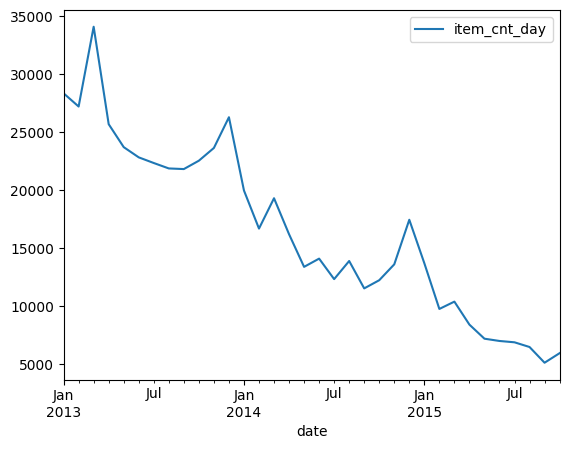

In [117]:
cat_40.plot()

In [118]:
group2 = df_sales_train.groupby('shop_name').agg({'item_cnt_day': 'sum'})
fig = px.bar(group2, x = group2.index, y = 'item_cnt_day', width=800, height=800).update_layout(
    xaxis_title="shop", yaxis_title= "Total sales per shop"
)

fig.update_xaxes(showticklabels=False)
fig.show()

In [119]:
df_shops[df_shops['shop_name'] == 'Москва ТЦ "Семеновский"']

,shop_name,shop_id
31,"Москва ТЦ ""Семеновский""",31


In [120]:
shop31 = df_sales_train[df_sales_train['shop_id'] == 31].groupby('date_block_num')[['date', 'item_cnt_day']].agg({'date': 'min', 'item_cnt_day': 'sum'}).set_index('date')
shop31.head()

,item_cnt_day
date,
2013-01-02,8826.0
2013-02-01,10019.0
2013-03-01,11513.0
2013-04-01,9056.0
2013-05-01,8788.0


<Axes: xlabel='date'>

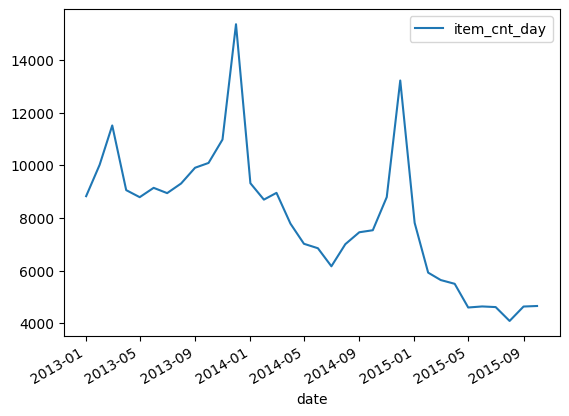

In [121]:
shop31.plot()